In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 

import os
from pathlib import Path

import plotly.offline as plty
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

from wordcloud import WordCloud
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from colorama import Fore, Back, Style, init

from tqdm import tqdm
tqdm.pandas()

In [2]:
!pip install -q pyspellchecker

In [3]:
PATH = Path('/kaggle/input/imdb-dataset-of-50k-movie-reviews/')

data = pd.read_csv(PATH / 'IMDB Dataset.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
data.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Mapping Sentiments to Numbers

In [5]:
data['sentiment'] = data['sentiment'].map({'positive' : 0, 'negative' : 1})

### Text Preprocessing

In [6]:
from spellchecker import SpellChecker
import spacy
import string, re

spell = SpellChecker()
PUNCT_TO_REMOVE = string.punctuation

def remove_punctuation(text):    
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))


def correct_spellings(text): 
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)


def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

In [7]:
def clean_text(text):
    
    # Lower Casing
    text = text.lower()
    
    # Remove url
    text = remove_urls(text) 
    
    # Remove html tags
    text = remove_html(text)
    
    # Removing @tags
    text = re.sub('@\w*','',text)
    
    # Removing Punctuations
    text = remove_punctuation(text)
    
    # Removing new lines
    text = re.sub('\\n',' ',text)
    
    # Correct spellings
    #text = correct_spellings(text)      
    
    return text

In [8]:
data["clean_text"] = data["review"].progress_apply(lambda text: clean_text(text))

100%|██████████| 50000/50000 [00:03<00:00, 14768.11it/s]


In [50]:
data[['review','clean_text']].head(10)

,review,clean_text
0,One of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,basically theres a family where a little boy j...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love in the time of money is a ...
5,"Probably my all-time favorite movie, a story o...",probably my alltime favorite movie a story of ...
6,I sure would like to see a resurrection of a u...,i sure would like to see a resurrection of a u...
7,"This show was an amazing, fresh & innovative i...",this show was an amazing fresh innovative ide...
8,Encouraged by the positive comments about this...,encouraged by the positive comments about this...
9,If you like original gut wrenching laughter yo...,if you like original gut wrenching laughter yo...



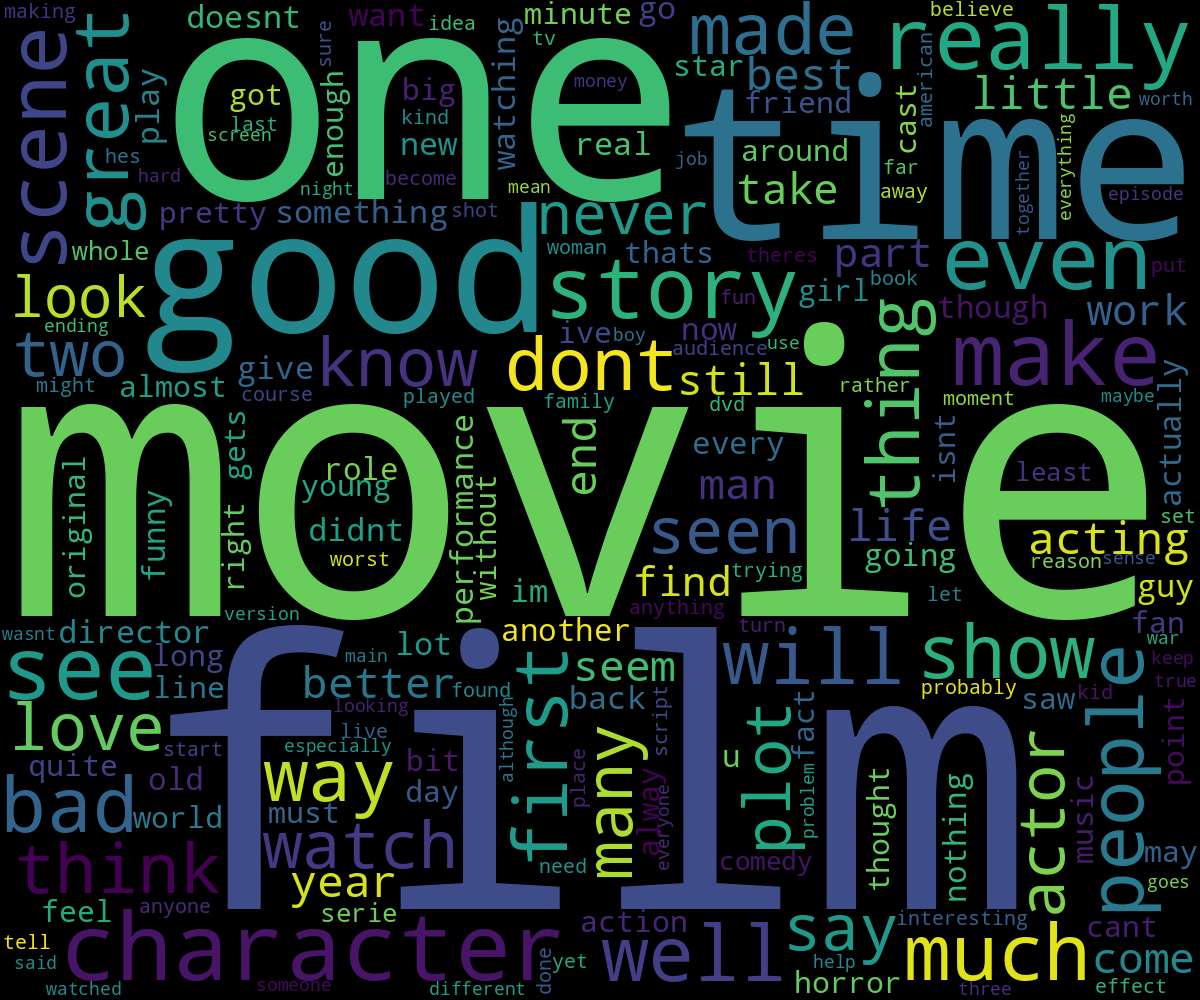

In [65]:
string = ' '.join(data['clean_text'])

wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(string.lower())
fig = px.imshow(wordcloud)
fig.update_layout(title_text='Common words in comments')

### Sentiment Analysis

In [66]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def polarity(text):
    if type(text) == str:
        return SIA.polarity_scores(text)
    else:
        return 1000
    
SIA = SentimentIntensityAnalyzer()
data["polarity"] = data["clean_text"].progress_apply(polarity)

100%|██████████| 50000/50000 [02:22<00:00, 350.15it/s]


In [67]:
import plotly.graph_objects as go

neg_pol = [pols['neg'] for pols in data["polarity"] if type(pols) is dict]
neg_pol = list(filter((0.0).__ne__, neg_pol))

fig = go.Figure(go.Histogram(x=neg_pol, marker=dict(
            color='red')
    ))

fig.update_layout(xaxis_title="Negativity sentiment", title_text="Negativity sentiment", template="simple_white")
fig.show()

From the above plot, we can see that negative sentiment has a strong rightward (positive) skew, indicating that negativity is usually on the lower side. This suggests that most comments are not toxic or negative. In fact, the most common negativity value is around 0.14. Virtually no comments have a negativity greater than 0.8.

In [68]:
toxic = [x['neg'] for x in data.query("sentiment == 1")['polarity'] if type(x) == dict]
non_toxic = [x['neg'] for x in data.query("sentiment == 0")['polarity'] if type(x) == dict]

fig = ff.create_distplot(hist_data=[toxic, non_toxic],
                         group_labels=["Negative", "Positive"],
                         colors=["darkorange", "dodgerblue"], show_hist=False)

fig.update_layout(title_text="Negativity of Bad vs Good tweets", xaxis_title="Negativity", template="simple_white")
fig.show()

We can clearly see that Neg comments have a significantly greater negative sentiment than Postive comments (on average). The probability density of negativity peaks at around 0 for non-toxic comments, while the negativity for toxic comments at 0.12 . This suggests that a comment is very likely to be non-toxic if it has a negativity of 0.

In [69]:
pos_pol = [pols['pos'] for pols in data["polarity"] if type(pols) is dict]
pos_pol = list(filter((0.0).__ne__, pos_pol))

fig = go.Figure(go.Histogram(x=pos_pol, marker=dict(
            color='seagreen')
    ))

fig.update_layout(xaxis_title="Positivity sentiment", title_text="Positivity sentiment", template="simple_white")
fig.show()

Most of the texts are Neutral by Looking at the low postivity & negativity, Let's look at netral values to confirm this

In [70]:
neu_pol = [pols['neu'] for pols in data["polarity"] if type(pols) is dict]
neu_pol = list(filter((1.0).__ne__, neu_pol))

fig = go.Figure(go.Histogram(x=neu_pol, marker=dict(
            color='darkorange')
    ))

fig.update_layout(xaxis_title="Neutral sentiment", title_text="Neutral sentiment", template="simple_white")
fig.show()

From the above plot, we can see that the neutrality sentiment distribution has a strong leftward (negative) skew, which is in constrast to the negativity and positivity sentiment distributions. This indicates that the comments tend to be very neutral and unbiased in general. This also suggests that most comments are not highly opinionated and polarizing, meaning that most comments are non-toxic.

In [71]:
total_comments = data['sentiment'].count()
neg = data['sentiment'].value_counts().loc[1]
Sentiment = ['Negative','Positive']
count = [neg, total_comments-neg]

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "bar"}, {"type": "pie"}]])
fig.add_trace(go.Bar(x=Sentiment,y=count,text=count, marker_color=['#D9636B', '#64D9D1']),
             row=1, col=1)
fig.add_trace(go.Pie(labels=Sentiment, values=count, domain=dict(x=[0.5, 1.0]), marker_colors=['#D9636B', '#64D9D1']), 
              row=1, col=2)

fig.update_layout(height=600, width=800, title_text="Negative vs Postive vs Neutral", template='plotly_white')

fig.show()


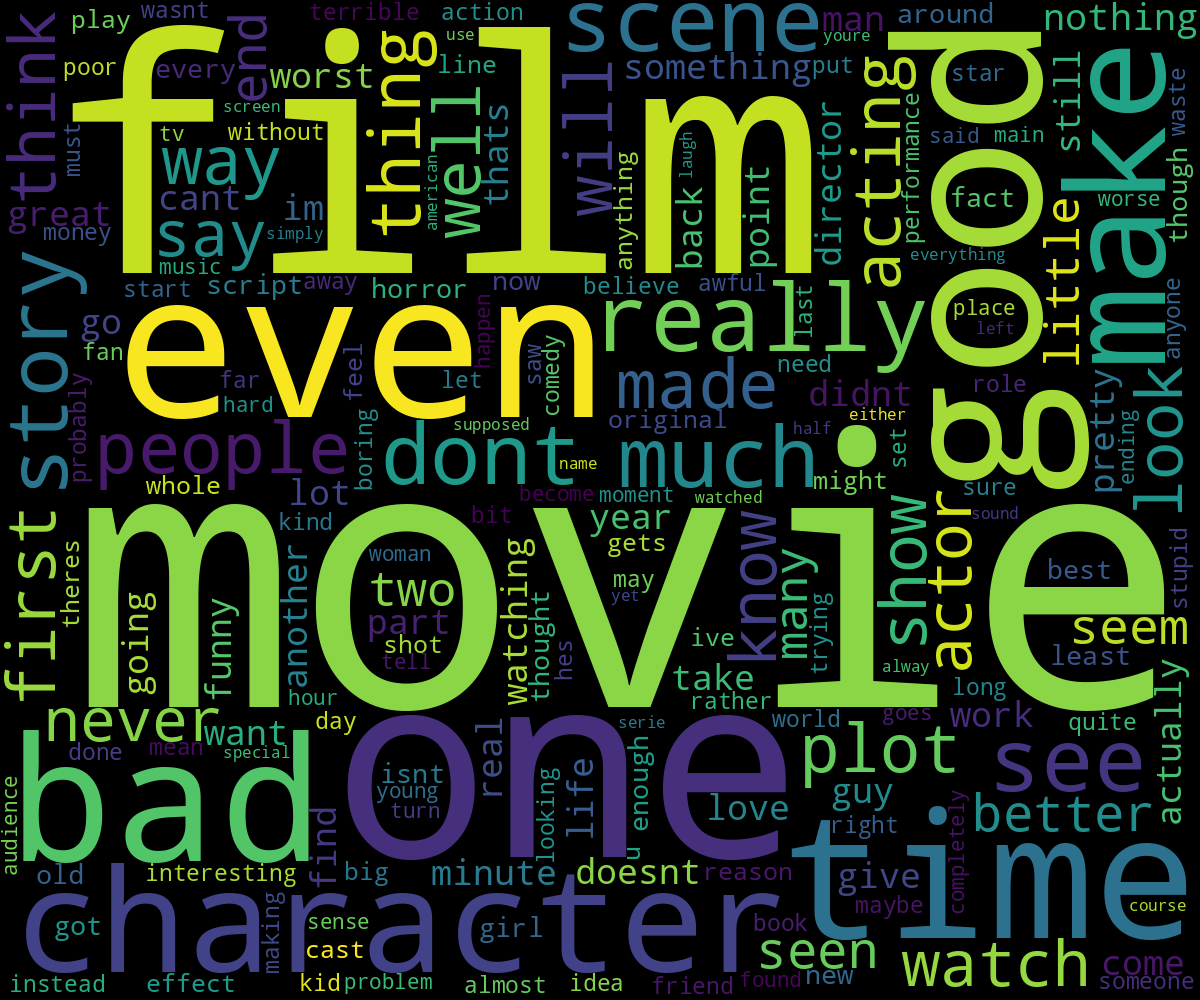

In [72]:
string = ' '.join(data.query('sentiment == 1')['clean_text'])

wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(string.lower())
fig = px.imshow(wordcloud)
fig.update_layout(title_text='Negative Reviews')


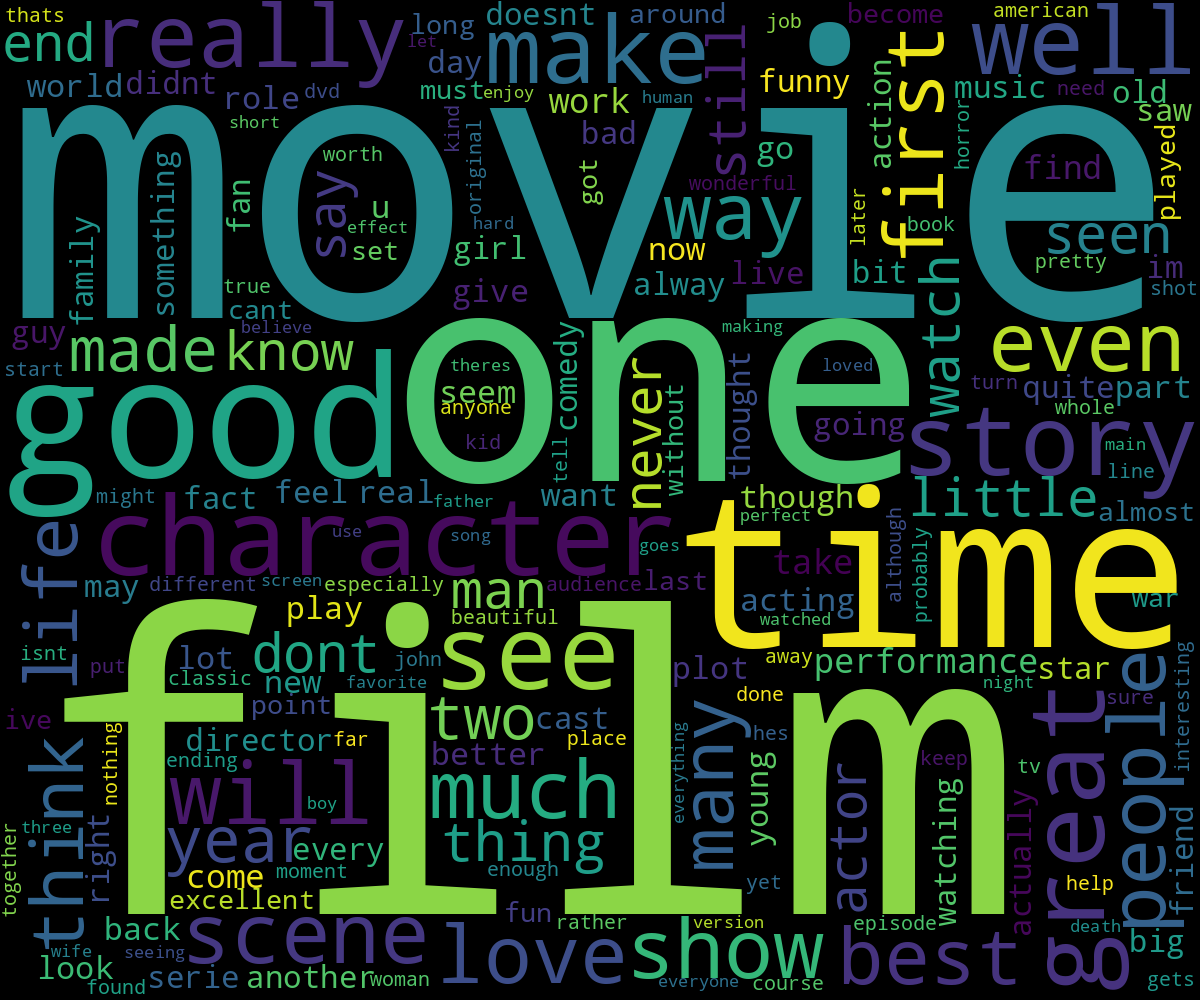

In [73]:
string = ' '.join(data.query('sentiment == 0')['clean_text'])

wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(string.lower())
fig = px.imshow(wordcloud)
fig.update_layout(title_text='Positive reviews')

In [9]:
import transformers
import tensorflow as tf
from tokenizers import BertWordPieceTokenizer

from tensorflow.keras.callbacks import Callback
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding
from tensorflow.keras.layers import LSTM, GRU, Conv1D, SpatialDropout1D

from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import activations
from tensorflow.keras import constraints
from tensorflow.keras import initializers
from tensorflow.keras import regularizers

import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.constraints import *
from tensorflow.keras.initializers import *
from tensorflow.keras.regularizers import *

### Bert Tokenizer

In [10]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

save_path = '/kaggle/working/distilbert_base_uncased/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

('/kaggle/working/distilbert_base_uncased/tokenizer_config.json',
 '/kaggle/working/distilbert_base_uncased/special_tokens_map.json',
 '/kaggle/working/distilbert_base_uncased/vocab.txt',
 '/kaggle/working/distilbert_base_uncased/added_tokens.json')

### Encoding

In [11]:
from sklearn.model_selection import train_test_split

X, y = data['clean_text'].values,data['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=111)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.125, 
                                                stratify=y_test, random_state=111)

In [12]:
X_train_tokens = tokenizer(list(X_train), padding='max_length', truncation=True, return_tensors="tf")
X_train_token_ids = X_train_tokens['input_ids']

X_test_tokens = tokenizer(list(X_test), padding='max_length', truncation=True, return_tensors="tf")
X_test_token_ids = X_test_tokens['input_ids']

X_val_tokens = tokenizer(list(X_val), padding='max_length', truncation=True, return_tensors="tf")
X_val_token_ids = X_val_tokens['input_ids']

2021-10-24 04:45:32.966667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-24 04:45:32.967864: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-24 04:45:32.968500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-24 04:45:32.971270: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [15]:
print(X_test_token_ids.shape)
print(X_train_token_ids.shape)

(10937, 512)
(37500, 512)


## Modelling

#### Loading the DistilBert Transformer & creating word embeddings

In [13]:
# Embedding:
transformer = transformers.TFDistilBertModel.\
    from_pretrained('distilbert-base-uncased')
embed = transformer.weights[0].numpy()

print('Vocab : ', np.shape(embed)[0], 'Hidden States/Embed vector size :', np.shape(embed)[1])

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

2021-10-24 04:46:28.189984: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the 

Vocab :  30522 Hidden States/Embed vector size : 768


In [14]:
MAX_LEN = 512
BATCH_SIZE = 12
STEPS_PER_EPOCH = X_train_token_ids.shape[0] // BATCH_SIZE

### Callback

In [18]:
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.3, patience=2, 
                                    verbose=1, mode='auto', 
                                    epsilon=0.0001, cooldown=1, min_lr=0.000001)

### Helper functions

In [39]:
def visualize_model_preds(y_pred, indices=[0, 1, 2, 3]):

    for idx, i in enumerate(indices):
        if y_test[i] == 0:
            label = "Non-toxic"
            color = f'{Fore.GREEN}'
            symbol = '\u2714'
        else:
            label = "Toxic"
            color = f'{Fore.RED}'
            symbol = '\u2716'

        print('{}{} {}'.format(color, str(idx+1) + ". " + label, symbol))
        print(f'{Style.RESET_ALL}')

        print(X_test[idx]); print("")
        fig = go.Figure()
        if y_test[i] == 1:
            yl = [1 - y_pred[i], y_pred[i]]
            
        else:
            yl = [1 - y_pred[i], y_pred[i]]

        fig.add_trace(go.Bar(x=['Positive', 'Negative'], y=yl, marker=dict(color=["seagreen", "indianred"])))
        fig.update_traces(name=X_test[idx])
        fig.update_layout(xaxis_title="Labels", yaxis_title="Probability", template="plotly_white", title_text="Predictions for validation comment #{}".format(idx+1))
        fig.show()
        
def plot_cm(y_true, y_pred, title, figsize=(7,6)):
    y_pred = y_pred.round().astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

### 1. Vanilla neural network

In [23]:
def vanilla_model():

    input_word_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_word_ids")


    embedding = Embedding(np.shape(embed)[0], np.shape(embed)[1],
                              input_length=MAX_LEN, weights=[embed],
                              trainable=False)(input_word_ids)

    x = K.sum(embedding, axis=2)
    x = Dense(512, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)
    

    model = Model(inputs=input_word_ids, outputs=out)

    model.compile(Adam(lr=0.001), 
                      loss='binary_crossentropy', 
                      metrics=['accuracy'])

    return model

In [24]:
van_model = vanilla_model()

train_history = van_model.fit(
    X_train_token_ids, y_train,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=(X_val_token_ids, y_val),
    epochs=7,
    callbacks = [reduceLROnPlat]
)

Epoch 1/7
3125/3125 [==============================] - 7s 2ms/step - loss: 1.1538 - accuracy: 0.5010 - val_loss: 0.6928 - val_accuracy: 0.5093
Epoch 2/7
3125/3125 [==============================] - 6s 2ms/step - loss: 0.6938 - accuracy: 0.5039 - val_loss: 0.6932 - val_accuracy: 0.5010
Epoch 3/7
3125/3125 [==============================] - 6s 2ms/step - loss: 0.6934 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4997

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/7
3125/3125 [==============================] - 7s 2ms/step - loss: 0.6933 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.4997
Epoch 5/7
3125/3125 [==============================] - 6s 2ms/step - loss: 0.6932 - accuracy: 0.4983 - val_loss: 0.6932 - val_accuracy: 0.4997

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 6/7
3125/3125 [==============================] - 6s 2ms/step - loss: 0.6932 - accuracy: 0.4976 - val_loss: 0.6932 - v

#### Evaluate & predict

In [25]:
van_model.evaluate(X_test_token_ids, y_test)

y_pred = van_model.predict(X_test_token_ids)

342/342 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.4999


### Classifying with probabilty threshold = 0.5

In [26]:
y_preds = y_pred > 0.5
y_preds = np.where(y_preds == True, 1, 0)

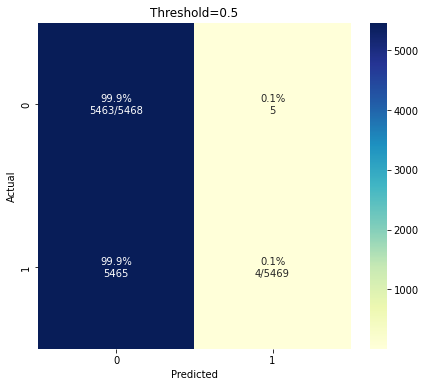

In [27]:
plot_cm(y_test, y_preds, 'Threshold=0.5')

In [28]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      5468
           1       0.44      0.00      0.00      5469

    accuracy                           0.50     10937
   macro avg       0.47      0.50      0.33     10937
weighted avg       0.47      0.50      0.33     10937



Very Poor Performance acheived from Vanilla network with all the positive classes missclassified.

We will be adjusting the probabilty threshold using G-Means

### Probability Threshold Moving : Finding the best Threshold

We have to search a range of threshold values in order to find the best threshold.
In some cases, the optimal threshold can be calculated directly. Tuning or shifting the decision threshold in order to accommodate the broader requirements of the classification problem is generally referred to as threshold-moving, threshold-tuning, or simply thresholding.

#### ROC curve

In [29]:
from sklearn.metrics import roc_curve, precision_recall_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred.reshape(y_test.shape[0]))
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)

print('Best Threshold=%f, G-mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.496368, G-mean=0.030


In [30]:
y_preds = y_pred > thresholds[ix]
y_preds = np.where(y_preds == True, 1, 0)

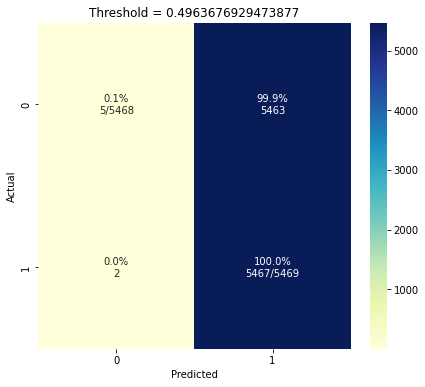

In [31]:
plot_cm(y_test, y_preds, f'Threshold = {thresholds[ix]}')

Great improvement in the Positve class using Probabilty Threshold moving , but vice versa for Negative class

### 2. Modelling with CNN

In [32]:
def build_cnn_model(max_len=MAX_LEN):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    
    embedding = Embedding(np.shape(embed)[0], np.shape(embed)[1],
                          input_length=max_len, weights=[embed],
                          trainable=False)(input_word_ids)
    
    embedding = SpatialDropout1D(0.3)(embedding)
    conv_1 = Conv1D(64, 2)(embedding)
    conv_2 = Conv1D(64, 3)(embedding)
    conv_3 = Conv1D(64, 4)(embedding)
    conv_4 = Conv1D(64, 5)(embedding)
    
    maxpool_1 = GlobalAveragePooling1D()(conv_1)
    maxpool_2 = GlobalAveragePooling1D()(conv_2)
    maxpool_3 = GlobalAveragePooling1D()(conv_3)
    maxpool_4 = GlobalAveragePooling1D()(conv_4)
    conc = concatenate([maxpool_1, maxpool_2, maxpool_3, maxpool_4], axis=1)

    conc = Dense(64, activation='relu')(conc)
    conc = Dense(1, activation='sigmoid')(conc)
    
    model = Model(inputs=input_word_ids, outputs=conc)
    
    model.compile(Adam(lr=0.01), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [33]:
cnn_model = build_cnn_model()

train_history = cnn_model.fit(
    X_train_token_ids, y_train,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=(X_val_token_ids, y_val),
    epochs=10,
    callbacks = [reduceLROnPlat]
)

Epoch 1/10


2021-10-23 17:52:24.005874: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


3125/3125 [==============================] - 28s 7ms/step - loss: 0.7016 - accuracy: 0.4960 - val_loss: 0.6939 - val_accuracy: 0.5003
Epoch 2/10
3125/3125 [==============================] - 22s 7ms/step - loss: 0.6937 - accuracy: 0.4938 - val_loss: 0.6932 - val_accuracy: 0.4997
Epoch 3/10
3125/3125 [==============================] - 22s 7ms/step - loss: 0.7458 - accuracy: 0.5006 - val_loss: 0.6934 - val_accuracy: 0.4997
Epoch 4/10
3125/3125 [==============================] - 22s 7ms/step - loss: 0.6939 - accuracy: 0.5021 - val_loss: 0.6933 - val_accuracy: 0.5003

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
Epoch 5/10
3125/3125 [==============================] - 22s 7ms/step - loss: 0.6932 - accuracy: 0.4993 - val_loss: 0.6932 - val_accuracy: 0.5003
Epoch 6/10
3125/3125 [==============================] - 22s 7ms/step - loss: 0.6933 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.5003

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.

### Poor performance from CNN model as well

### 3. LSTM + Attention Layer

In [34]:
class AttentionWeightedAverage(Layer):

    def __init__(self, return_attention=False, **kwargs):
        self.init = initializers.get('uniform')
        self.supports_masking = True
        self.return_attention = return_attention
        super(AttentionWeightedAverage, self).__init__(** kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(ndim=3)]
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[2], 1),
                                 name='{}_W'.format(self.name),
                                 initializer=self.init)
        super(AttentionWeightedAverage, self).build(input_shape)

    def call(self, x, mask=None):
        logits = K.dot(x, self.W)
        x_shape = K.shape(x)
        logits = K.reshape(logits, (x_shape[0], x_shape[1]))
        ai = K.exp(logits - K.max(logits, axis=-1, keepdims=True))

        if mask is not None:
            mask = K.cast(mask, K.floatx())
            ai = ai * mask
        att_weights = ai / (K.sum(ai, axis=1, keepdims=True) + K.epsilon())
        weighted_input = x * K.expand_dims(att_weights)
        result = K.sum(weighted_input, axis=1)
        if self.return_attention:
            return [result, att_weights]
        return result

    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)

    def compute_output_shape(self, input_shape):
        output_len = input_shape[2]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0], input_shape[1])]
        return (input_shape[0], output_len)

    def compute_mask(self, input, input_mask=None):
        if isinstance(input_mask, list):
            return [None] * len(input_mask)
        else:
            return None

In [35]:
def build_lstm_model(max_len=MAX_LEN):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    
    embed = transformer.weights[0].numpy()
    embedding = Embedding(np.shape(embed)[0], np.shape(embed)[1],
                          input_length=max_len, weights=[embed],
                          trainable=False)(input_word_ids)
    
    embedding = SpatialDropout1D(0.3)(embedding)
    lstm_1 = LSTM(128, return_sequences=True)(embedding)
    lstm_2 = LSTM(128, return_sequences=True)(lstm_1)
    
    attention = AttentionWeightedAverage()(lstm_2)
    conc = Dense(64, activation='relu')(attention)
    conc = Dense(1, activation='sigmoid')(conc)
    
    model = Model(inputs=input_word_ids, outputs=conc)
    
    model.compile(Adam(lr=0.01), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [36]:
lstm_model = build_lstm_model()

train_history = lstm_model.fit(
    X_train_token_ids, y_train,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=(X_val_token_ids, y_val),
    epochs=6,
    callbacks = [reduceLROnPlat]
)

Epoch 1/6
3125/3125 [==============================] - 149s 47ms/step - loss: 0.6943 - accuracy: 0.4973 - val_loss: 0.6945 - val_accuracy: 0.5003
Epoch 2/6
3125/3125 [==============================] - 147s 47ms/step - loss: 0.6933 - accuracy: 0.5057 - val_loss: 0.6936 - val_accuracy: 0.4997
Epoch 3/6
3125/3125 [==============================] - 147s 47ms/step - loss: 0.6936 - accuracy: 0.5018 - val_loss: 0.6932 - val_accuracy: 0.5003
Epoch 4/6
3125/3125 [==============================] - 147s 47ms/step - loss: 0.6935 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.4997
Epoch 5/6
3125/3125 [==============================] - 147s 47ms/step - loss: 0.6936 - accuracy: 0.4970 - val_loss: 0.6932 - val_accuracy: 0.5003

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
Epoch 6/6
3125/3125 [==============================] - 147s 47ms/step - loss: 0.6933 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.5003


The models using CNN, LSTM & Vanilla network did not perform good at all, these models could not learn the Dataset and performed somewhat same.

### 4. Bert Transformer

In [16]:
bert_transformer = transformers.TFDistilBertModel.\
    from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [17]:
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')
y_val = y_val.astype('int32')

In [19]:
def build_bert_model(maxlen=MAX_LEN):
    input_ids = Input(shape=(maxlen,), dtype=tf.int32, name="input_word_ids")
    embeddings = bert_transformer(input_ids)[0]

    cls_token = embeddings[:, 0, :]
    x = Dense(maxlen, activation="relu")(cls_token)
    x = Dropout(0.5)(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_ids, outputs=out)

    model.compile(Adam(learning_rate=1.5e-5), 
                      loss='binary_crossentropy', 
                      metrics=['accuracy'])
    
    return model

In [20]:
model = build_bert_model()

train_history = model.fit(
    X_train_token_ids, y_train,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=(X_val_token_ids, y_val),
    epochs=2
)

2021-10-24 04:50:37.468750: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2
3125/3125 [==============================] - 1254s 400ms/step - loss: 0.2595 - accuracy: 0.8882 - val_loss: 0.2075 - val_accuracy: 0.9162
Epoch 2/2
3125/3125 [==============================] - 1246s 399ms/step - loss: 0.1497 - accuracy: 0.9444 - val_loss: 0.2021 - val_accuracy: 0.9271


In [21]:
y_pred = model.predict(X_test_token_ids)

In [29]:
y_pred = y_pred.reshape(y_pred.shape[0])

In [34]:
y_pred[:10]

array([0.00268586, 0.99951017, 0.01591912, 0.99616146, 0.9935097 ,
       0.984193  , 0.9768763 , 0.99622464, 0.97323316, 0.9991935 ],
      dtype=float32)

In [38]:
visualize_model_preds(y_pred)

1. Non-toxic ✔

ORIGINAL
well if you are openminded enough to have liked barber shop then you will like this canadian filmif your mind is as closedminded as fort knox then you will give it the current score that it has  25this is a film for anybody prepared to watch films from outside of their own racial grounds it is engaging it is true to life on two or three occasions you lose the connections between the scenes but many times especially towards the end you find yourself having a tear or two in your eyes and this simply because it so often mirrors what life can be likei like it and recommend it to anyone open minded beyond the traditional american film

[0.9973141448572278, 0.0026858551]


2. Toxic ✖

ORIGINAL
ouch they dont come much worse than this horrid adaptation of c s lewiss beloved novel while the adaptation is very true to the novel the acting is simply awful and the sets and special effects are on a scale equivalent to a school play ive read that the budget for this miniseries was the grandest that the bbc has ever given at the time but surely they could have scraped together a bit more than the 2 that it looks like this was filmed for the worst effect of all is mr beaver i know computer effects werent at the level necessary or even cost effective at the time but the costume store man in a suit look was horrid better to have just cut the character from the film than do that to the role avoid this at all costs

[0.0004898309707641602, 0.99951017]


3. Non-toxic ✔

ORIGINAL
this is a great movie from the lost age of reactionary madefortelevision drama my alltime favourite actor robert culp skillfully plots a trajectory through uptight liberal fairmindedness and faith in the system kneejerk conservativism and fear of crime and homicidal psychosis the teens are a collection of pure sneering evil stereotypes and the eventual message of this film makes episodes of dragnet look evenhanded by comparison but what really shines in this is the great pace of the movie building the fear and paranoia by degrees as well as the feel of the whole california setting the cars are really great as well as i recall i give this film a 10 and i defy anyone to watch this film and not enjoy every minute remember just because its madefortelevision doesnt mean it isnt great art

[0.9840808752924204, 0.015919125]


4. Toxic ✖

ORIGINAL
and this movie has crossed it i have never seen such a terrible movie in my life i mean a kids head getting cut off from the force of an empty sled a snowman with a costume that has the seams clearly visible this was a pitiful excuse for a movie

[0.0038385391235351562, 0.99616146]


In [55]:
y_preds = y_pred > 0.5
y_preds = np.where(y_preds == True, 1, 0)

### Accuracy

In [56]:
old_accuracy = accuracy_score(y_preds, y_test)
old_accuracy

0.9226478924750846

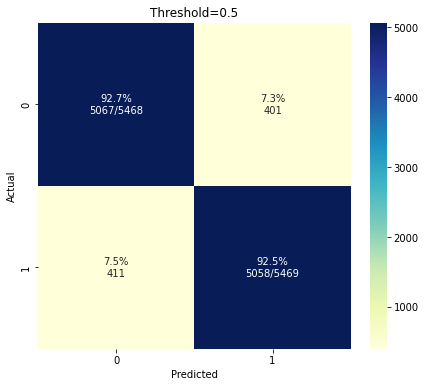

In [49]:
plot_cm(y_test, y_preds, 'Threshold=0.5')

### Finding the optimal threshold using ROC-AUC

In [50]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
gmeans = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans)

print('Best Threshold=%f, G-mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.633717, G-mean=0.926


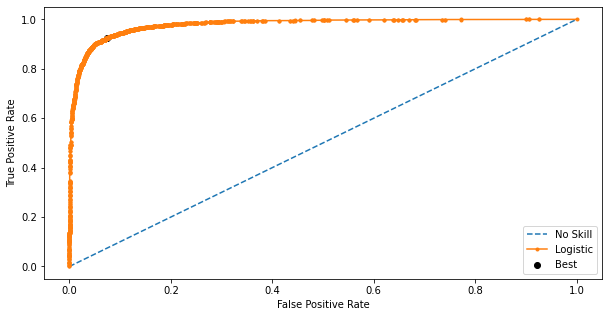

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill') 

plt.plot(fpr, tpr, marker='.', label='Logistic') 
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best') 
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

### Classifying using optimal threshold

In [58]:
y_preds = (y_pred > thresholds[ix])
y_preds = np.where(y_preds == True, 1, 0)

In [63]:
new_accuracy = accuracy_score(y_preds, y_test)


print(f'Percent increase in accuracy after threshold moving = {((new_accuracy - old_accuracy)/old_accuracy) * 100}')

Percent increase in accuracy after threshold moving = 0.3369339014963842


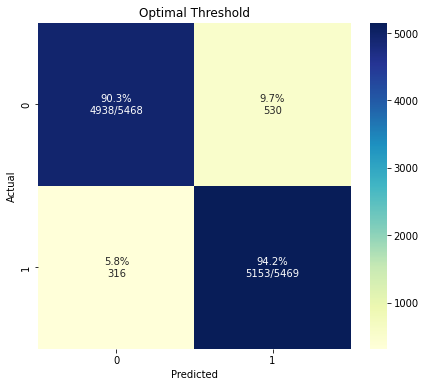

In [64]:
plot_cm(y_test, y_pred, 'Optimal Threshold')